University of Michigan - ROB 101 Computational Linear Algebra

# Soft Margin Classifier

In [4]:
using Pkg
Pkg.add("OSQP")
Pkg.add("Compat")

   Resolving package versions...
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Manifest.toml`


**Soft Margin RBF Classifier**

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \xi^\top \xi + \frac{\lambda}{2} w^\top w \\
  \mbox{subject to} & y_i (w^\top \phi_i) \geq 1 - \xi_i \qquad i = 1,\dots,n
\end{array}\end{split}

We can write this as

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \begin{bmatrix} w \\ \xi \end{bmatrix}^\top \begin{bmatrix} \lambda I_m & 0_{m\times n} \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \\
  \mbox{subject to} & \begin{bmatrix} -\infty_n \\ 0_n \end{bmatrix} \leq \begin{bmatrix} \Phi_{n\times m} & -I_n \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \leq \begin{bmatrix} -1_n \\ \infty_n \end{bmatrix}
\end{array}\end{split}

where now $m = n + 1$, 
$$ \Phi_{n\times m} = \begin{bmatrix} -y_1 \phi_1^\top \\ \vdots \\ -y_n \phi_n^\top \end{bmatrix}.$$


In [19]:
# generate a dataset
n = 200; # number data points
stop = false;
k1 = 0; # number of 1
k2 = 0; # number of -1
X = zeros(n,2); # input matrix
t = zeros(n,1); # target values
i = 1;
while !stop
    x = rand(1,2) * 10.;
    y = (x[1]-5)^2 + (x[2]-5)^2;
    # generate target values
    if (y < 5.5) && k1 < n/2
        t[i] = 1;
        X[i,:] = x;
        k1 += 1;
        i += 1;
    elseif (y > 4) && k2 < n/2
        t[i] = -1;
        X[i,:] = x;
        k2 += 1;
        i += 1;
    elseif k1 > (n/2-1) && k2 > (n/2-1)
        break;
    end
end

# Class +1 IDs
class1_id = t .== 1;

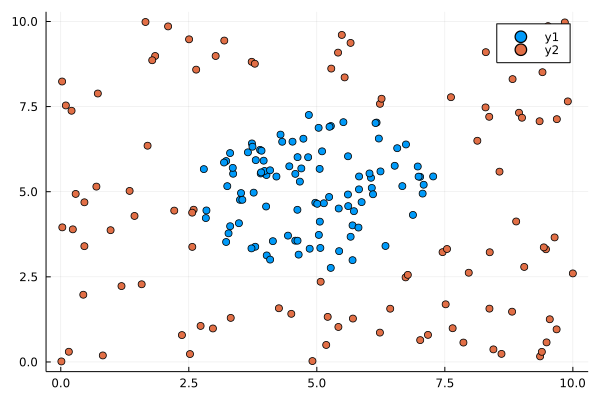

In [20]:
using Plots
gr() # Set the backend to GR

plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

In [21]:
using LinearAlgebra 

# Radial basis function
s = 1;
rbf(x, z, s) = exp.(-norm(x-z)^2 / (2*s^2));

function calc_phi_row(x, z, s)
    
    phi_row_size = size(z, 1) + 1
    phi_row = Array{Float64, 1}(undef, phi_row_size)
    phi_row[1] = 1
    
    for i in 2:phi_row_size
        phi_row[i] = rbf(x, z[i-1, :], s)
    end
    
    return phi_row
end

function regressor_matrix(X, centers, s)
    
    N = size(X, 1)
    M = size(centers, 1)
    phi = Array{Float64, 2}(undef, N, M+1)
    
    for i in 1:N
        phi[i, :] = calc_phi_row(X[i, :], centers, s)'
    end
    
    return phi
end

regressor_matrix (generic function with 1 method)

In [22]:
using OSQP
using SparseArrays

# Define problem data
m = n+1;
λ = 1; # tunable parameter (called hyperparameter because it's not like w the parameter of our model)
P = sparse([λ*(zeros(m,m) + I) zeros(m,n); zeros(n,m) (zeros(n,n) + I)]);
q = zeros(n+m,1);
Phi = regressor_matrix(X,X,s);
A = sparse([-t.*Phi -(zeros(n,n) + I); zeros(n,m) (zeros(n,n) + I)])
l = [zeros(n,1) .- Inf; zeros(n,1)];
u = [-ones(n,1); zeros(n,1) .+ Inf];

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q[:], A=A, l=l[:], u=u[:])

# Solve problem
results = OSQP.solve!(prob);

println(results.x)

[-0.8100417423456239, -0.05001604366933103, -0.24015925037165034, -0.22291337897949048, -0.1299847802290714, -0.019866470513637265, -0.0386393229558919, 0.13170695369494617, -0.10712385752399481, -0.10827730291997088, 0.09936297325020518, -0.03555885601752044, -0.31455931123670117, -0.04099241903875188, -0.1799264938499857, -0.022443026640815232, 0.10068604804940288, -0.15862051352694279, 0.06459828087366493, 0.12665676053268343, -0.06292400011478701, -0.038022827451454064, 0.20958440855525465, -0.11868287407451762, 0.14839748177883472, -0.17434236910940254, -0.00449532868778554, -0.028887712600969492, -0.09822434490831605, -0.02509955075660076, -0.1588331044433663, -0.056889728596248586, 0.17020541369038328, 0.15495592861947172, -0.10927746730294333, -0.19444409852693226, -0.16260908953006206, -0.06882372782419222, -0.023085659515254243, -0.06399491838296612, -0.034789092102189, 0.14100201803779527, -0.07214460907563619, -0.029608628295094662, -0.03775262646455546, 0.12595611101524723

In [23]:
# create test data
x1 = 0:0.1:10;
x2 = 0:0.1:10;
X1 = zeros(length(x2),length(x1));
X2 = zeros(length(x2),length(x1));
for j=1:length(x1)
    for i=1:length(x2)
        X1[i,j]= x1[j]
        X2[i,j]= x2[i]
    end
end
X_test = [X1[:] X2[:]];
# get model weights
α = results.x[1:201,:]
# query
Phi_test = regressor_matrix(X_test,X,s);
Y_test = Phi_test * α;

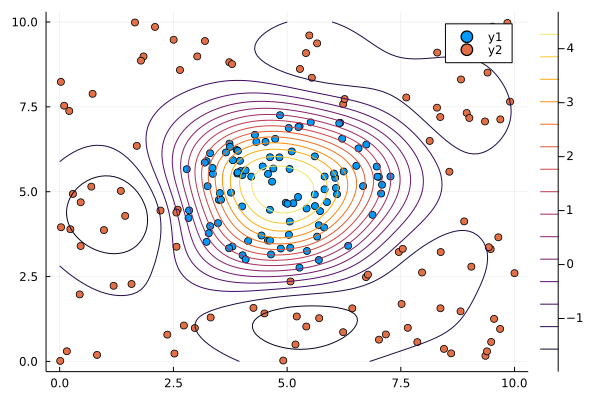

In [24]:
Z = reshape(Y_test, (length(x2), length(x1)));
# plot the margins
contour!(x1,x2,Z)

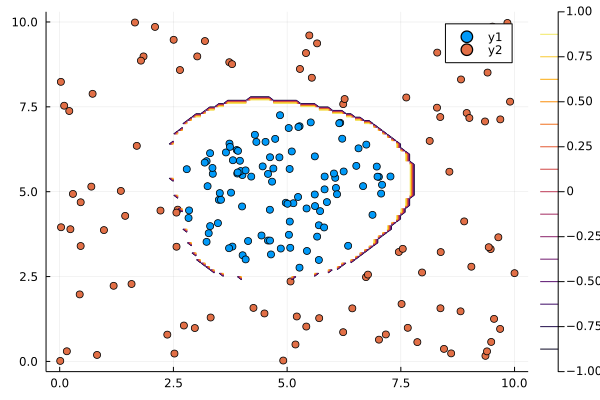

In [25]:
plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

Z = sign.(reshape(Y_test, (length(x2), length(x1))));
# plot the margins
contour!(x1,x2,Z)